In [1]:
from gekko import GEKKO 
import numpy as np 
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt 

In [8]:
def sis(t,i,beta,gamma):
    return beta*(1-i)*i-gamma*i 
m=GEKKO()
nt=500
i0=0.01
beta_list=[0.03,1]
gamma=0.1
b=15
tf=10
u_max=1
time=np.linspace(0,tf,nt)
X_control=np.zeros((len(beta_list),time.shape[0]))
X_normal=np.zeros((len(beta_list),time.shape[0]))
U=np.zeros((len(beta_list),time.shape[0]))
for index,beta in enumerate(beta_list):
    m.time=time
    x1=m.Var(value=i0,lb=0,ub=1)
    x2=m.Var(value=0)
    u=m.Var(value=0,lb=0,ub=u_max)
    p=np.zeros(nt)
    p[-1]=1
    final = m.Param(value=p)
    m.Equation(x1.dt()==-beta*x1**2+(beta-gamma-u)*x1+u)
    m.Equation(x2.dt()==b*u**2)
    m.Obj(-x1*final+x2*final)
    m.options.IMODE=6
    m.solve(disp=False)
    X_control[index,:]=list(x1.value)
    U[index,:]=list(u.value)
    sol=solve_ivp(lambda t,i: sis(t,i,beta,gamma),[0,tf],[i0],t_eval=time)
    X_normal[index,:]=sol.y[0]





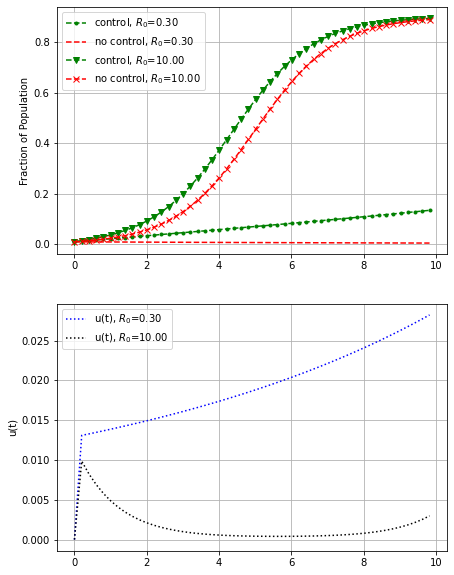

In [9]:
def graphics(ax,X_control,X_normal,U,beta_list,gamma,ns,index,control_color,normal_color,u_color,shape):
    ax[0].plot(time[::ns],X_control[index][::ns],shape[0],color=control_color,label='control, $R_0$=%0.2f'%(beta_list[index]/gamma))
    ax[0].plot(time[::ns],X_normal[index][::ns],shape[1],color=normal_color,label='no control, $R_0$=%0.2f'%(beta_list[index]/gamma))
    ax[0].legend()
    
    ax[1].plot(time[::ns],U[index][::ns],shape[2],color=u_color,label='u(t), $R_0$=%0.2f'%(beta_list[index]/gamma))
    ax[1].legend()


ns=10
fig,ax=plt.subplots(2,1,figsize=(7,10))

graphics(ax,X_control,X_normal,U,beta_list,gamma,ns,0,'g','r','b',['--.','--',':'])
graphics(ax,X_control,X_normal,U,beta_list,gamma,ns,1,'g','r','black',['--v','--x',':'])
ax[0].grid()
ax[0].set_ylabel('Fraction of Population')
ax[1].grid()
ax[1].set_ylabel('u(t)')
plt.show()
